In [1]:
# Import necessary libraries
import pandas as pd
from datetime import datetime

# Load the dataset
logon_path = 'E:\Dataset\Computer Emergency Response Team (CERT) r6.2/r6.2/r6.2/Newprocessed_logon.csv'
logon_df = pd.read_csv(logon_path)

print(logon_df.head())


                         id                 date     user       pc activity  \
0  {F3X8-Y2GT43DR-4906OHBL}  2010-01-02 02:19:18  DNS1758  PC-0414    Logon   
1  {B4Q0-D0GM24KN-3704MAII}  2010-01-02 02:31:12  DNS1758  PC-0414   Logoff   
2  {T7J1-D4HK34KV-5476TCIJ}  2010-01-02 02:34:02  DNS1758  PC-5313    Logon   
3  {S4Y6-D8MQ05SA-0759HLIS}  2010-01-02 02:53:30  DNS1758  PC-5313   Logoff   
4  {F3P0-E7FH78CV-4874FRGZ}  2010-01-02 04:07:31  DNS1758  PC-0012    Logon   

   day_of_week  hour  Weekday_Logon_After  Weekday_Logon_Normal  Weekend_Logon  
0            5     2                    0                     0              1  
1            5     2                    0                     0              1  
2            5     2                    0                     0              1  
3            5     2                    0                     0              1  
4            5     4                    0                     0              1  


In [2]:
logon_df['date'] = pd.to_datetime(logon_df['date'])


In [3]:
# Sort the data by user, pc, and date
logon_df = logon_df.sort_values(by=['user', 'pc', 'date'])

# Calculate the time difference between the current row and the next row within each group
logon_df['session_duration'] = logon_df.groupby(['user', 'pc'])['date'].diff()

# Filter rows where the activity is 'Logon', as we want to associate session_duration with logon events
logon_sessions = logon_df[logon_df['activity'] == 'Logon'].copy()

In [4]:
print(logon_sessions)

                               id                date     user       pc  \
2686     {Z9U4-E5DO62XF-0940IUMN} 2010-01-04 07:41:00  AAB0162  PC-6599   
12559    {T4O2-L6DA48LD-1984MYGZ} 2010-01-05 07:46:00  AAB0162  PC-6599   
22815    {V1K3-F2NB85JZ-3087FZKU} 2010-01-06 07:45:00  AAB0162  PC-6599   
32605    {K9G3-Z1VF57JC-7874ZYZM} 2010-01-07 07:45:00  AAB0162  PC-6599   
43329    {G1N9-G7RU74VO-2662MTBS} 2010-01-08 07:50:00  AAB0162  PC-6599   
...                           ...                 ...      ...      ...   
3484156  {K8V3-J5PM72WX-7430YNHJ} 2011-05-24 07:38:00  ZZO2997  PC-3120   
3493388  {K9L2-P3MW26AW-5462IDFS} 2011-05-25 07:46:00  ZZO2997  PC-3120   
3502887  {Z7Y7-Y7IT17CH-7201ZNYS} 2011-05-26 07:44:00  ZZO2997  PC-3120   
3512005  {W9X0-V4OJ55RL-2202TUTQ} 2011-05-27 07:40:00  ZZO2997  PC-3120   
3522578  {V9P3-W9EA34VY-5144TIYL} 2011-05-31 07:49:00  ZZO2997  PC-3120   

        activity  day_of_week  hour  Weekday_Logon_After  \
2686       Logon            0     7    

In [5]:
logon_sessions['session_duration'] = logon_sessions['session_duration'].dt.total_seconds()

In [6]:
logon_sessions['session_duration'] = logon_sessions['session_duration'].apply(lambda x: max(0, x))
logon_sessions['session_duration'] = logon_sessions['session_duration'].fillna(0)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
print(logon_sessions['session_duration'].describe())


count    1.948933e+06
mean     2.068384e+05
std      1.726895e+06
min      0.000000e+00
25%      2.034800e+04
50%      5.070000e+04
75%      5.700000e+04
max      4.431137e+07
Name: session_duration, dtype: float64


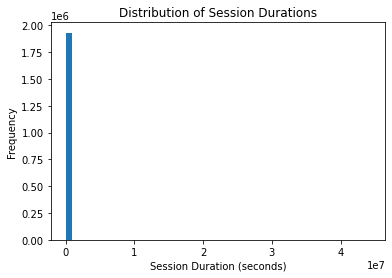

In [9]:
plt.hist(logon_sessions['session_duration'], bins=50)
plt.title('Distribution of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

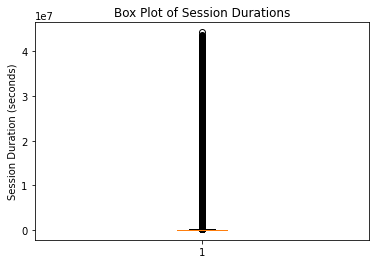

In [10]:
plt.boxplot(logon_sessions['session_duration'])
plt.title('Box Plot of Session Durations')
plt.ylabel('Session Duration (seconds)')
plt.show()


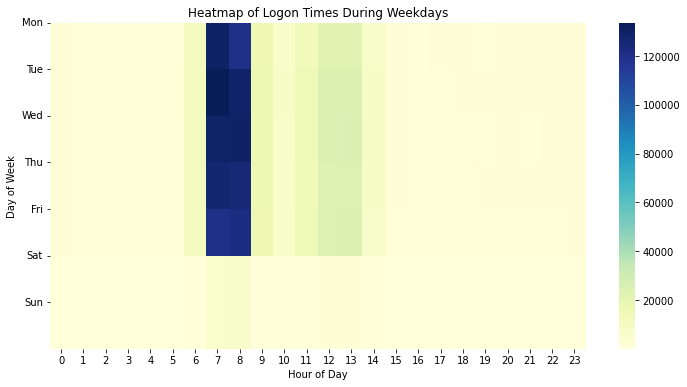

In [11]:
logon_sessions['day_of_week'] = logon_sessions['date'].dt.dayofweek
logon_sessions['hour_of_day'] = logon_sessions['date'].dt.hour

weekday_hour_counts = logon_sessions.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='count')
weekday_hour_pivot = weekday_hour_counts.pivot('day_of_week', 'hour_of_day', 'count')

plt.figure(figsize=(12, 6))
sns.heatmap(weekday_hour_pivot, cmap='YlGnBu')
plt.title('Heatmap of Logon Times During Weekdays')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

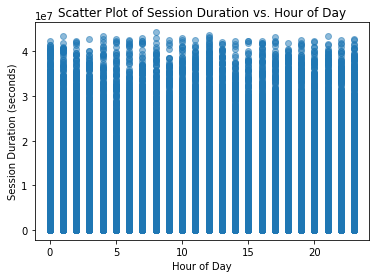

In [12]:
plt.scatter(logon_sessions['hour_of_day'], logon_sessions['session_duration'], alpha=0.5)
plt.title('Scatter Plot of Session Duration vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (seconds)')
plt.show()


In [13]:
import numpy as np


In [14]:
np.random.seed(0)
random_indices = np.random.choice(logon_sessions.index, size=5, replace=False)
logon_sessions['is_anomalous'] = 0
logon_sessions.loc[random_indices, 'is_anomalous'] = 1

In [15]:
print(random_indices)

[2190962 3484671 3410022 2545206 1261179]


In [16]:
logon_sessions['in_office_hours'] = ((logon_sessions['day_of_week'] < 5) & 
                                     (logon_sessions['hour_of_day'] >= 9) & 
                                     (logon_sessions['hour_of_day'] < 17)).astype(int)


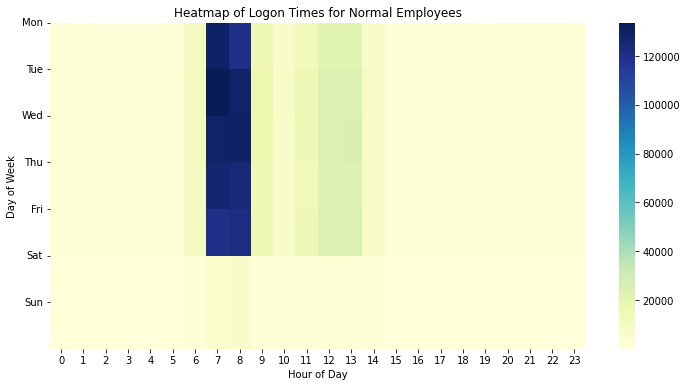

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

normal_sessions = logon_sessions[logon_sessions['is_anomalous'] == 0]
normal_heatmap_data = normal_sessions.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='count')
normal_heatmap_pivot = normal_heatmap_data.pivot('day_of_week', 'hour_of_day', 'count')

plt.figure(figsize=(12, 6))
sns.heatmap(normal_heatmap_pivot, cmap='YlGnBu')
plt.title('Heatmap of Logon Times for Normal Employees')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


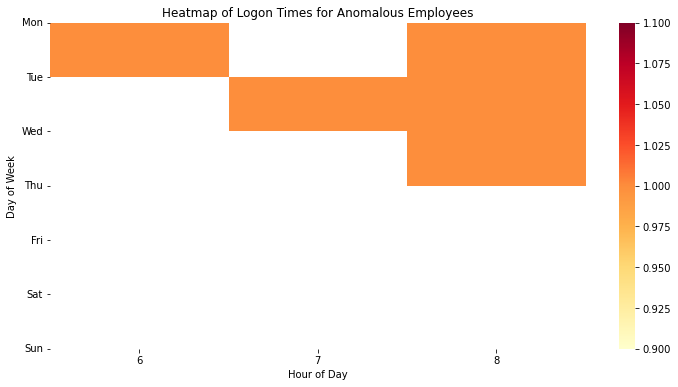

In [18]:
anomalous_sessions = logon_sessions[logon_sessions['is_anomalous'] == 1]
anomalous_heatmap_data = anomalous_sessions.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='count')
anomalous_heatmap_pivot = anomalous_heatmap_data.pivot('day_of_week', 'hour_of_day', 'count')

plt.figure(figsize=(12, 6))
sns.heatmap(anomalous_heatmap_pivot, cmap='YlOrRd')
plt.title('Heatmap of Logon Times for Anomalous Employees')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


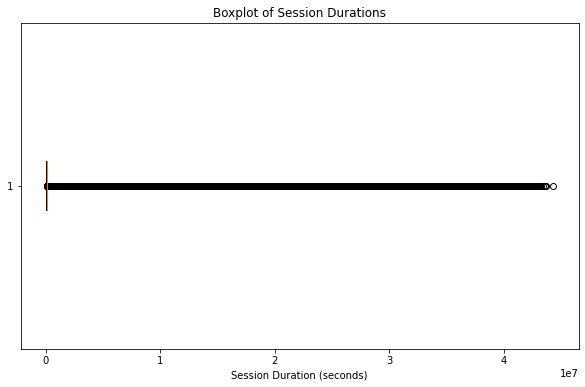

In [19]:
# Normal Behaviour

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(logon_sessions['session_duration'], vert=False)
plt.title('Boxplot of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.show()


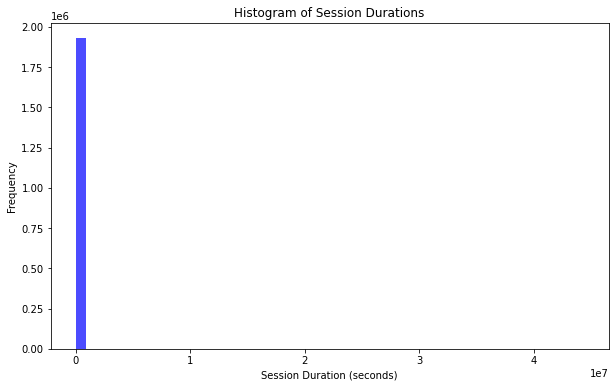

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(logon_sessions['session_duration'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


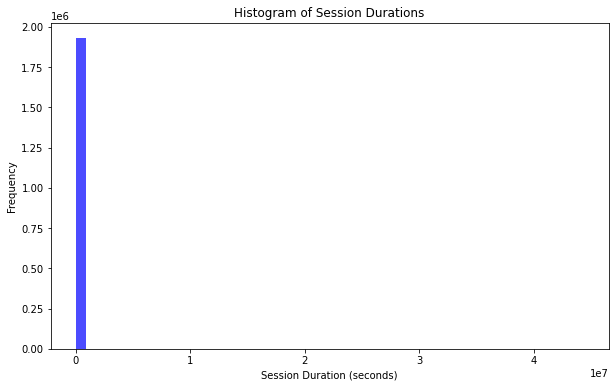

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(logon_sessions['session_duration'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


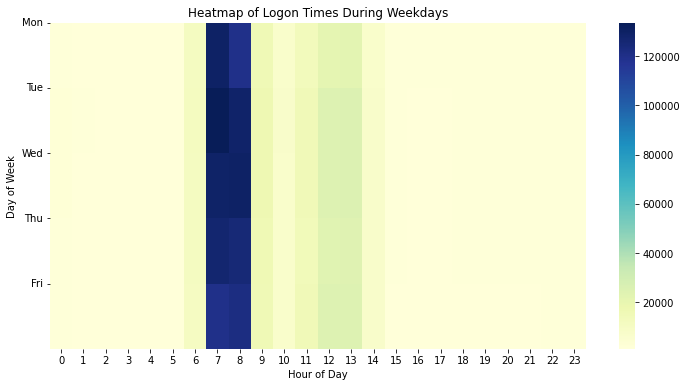

In [22]:
import seaborn as sns

# Filter for weekdays
weekday_sessions = logon_sessions[logon_sessions['day_of_week'] < 5]

# Group by day_of_week and hour_of_day, and count the number of sessions
heatmap_data = weekday_sessions.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='count')

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot('day_of_week', 'hour_of_day', 'count')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap='YlGnBu')
plt.title('Heatmap of Logon Times During Weekdays')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(5), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], rotation=0)
plt.show()


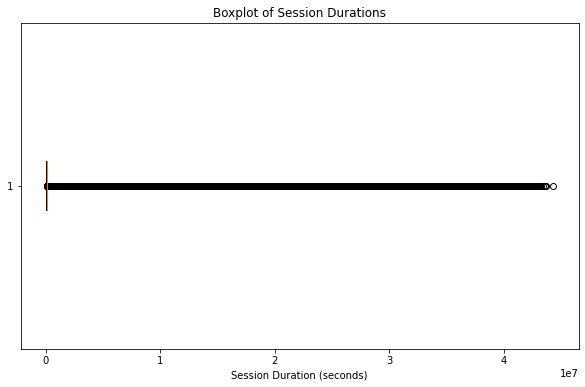

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(logon_sessions['session_duration'], vert=False)
plt.title('Boxplot of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.show()


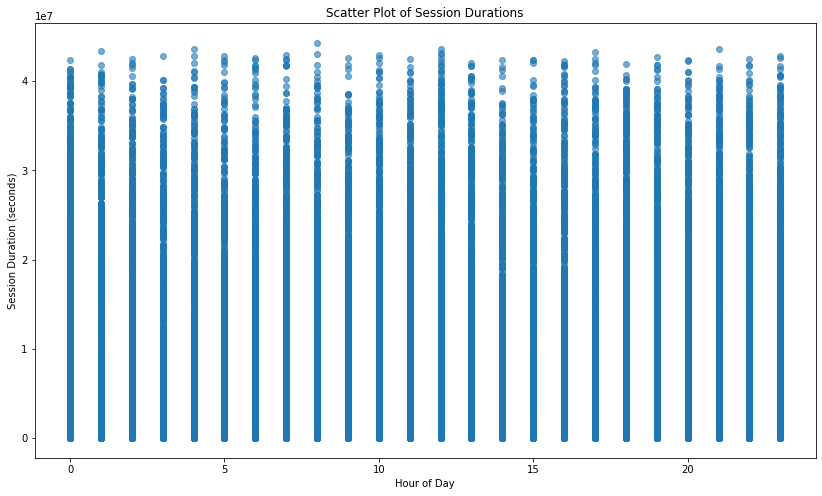

In [24]:
plt.figure(figsize=(14, 8))
plt.scatter(logon_sessions['hour_of_day'], logon_sessions['session_duration'], alpha=0.6)
plt.title('Scatter Plot of Session Durations')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (seconds)')
plt.show()


In [26]:
import matplotlib.pyplot as plt


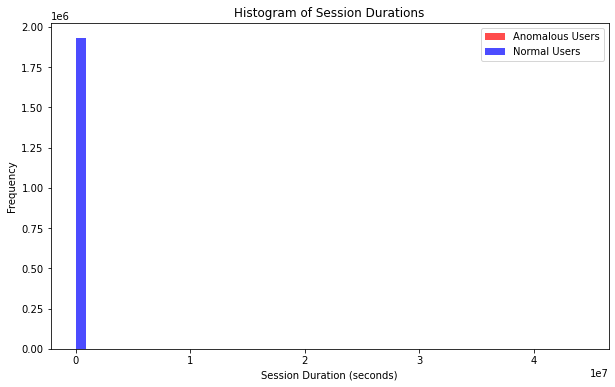

In [27]:
# Example of known anomalous users
anomalous_users = ['user1', 'user2', 'user3', 'user4', 'user5']

plt.figure(figsize=(10, 6))
plt.hist(logon_sessions[logon_sessions['user'].isin(anomalous_users)]['session_duration'], bins=50, color='red', alpha=0.7, label='Anomalous Users')
plt.hist(logon_sessions[~logon_sessions['user'].isin(anomalous_users)]['session_duration'], bins=50, color='blue', alpha=0.7, label='Normal Users')
plt.title('Histogram of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
